In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.io import loadmat
from scipy.optimize import minimize
from pathlib import Path

In [2]:
# Images directory

figsdir = Path.cwd() / 'ex4figs'
figsdir.mkdir(parents=True, exist_ok=True);

In [3]:
# Data directory

datadir = Path.cwd() / 'data/ex4'

# Neural networks and backpropagation

In [4]:
# Load data

data = loadmat(datadir / 'ex4data1.mat')
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])

In [5]:
x = np.c_[np.ones(data['X'].shape[0]), data['X']]
y = data['y']
print('X: {} (intercept incl.)\ny: {}'.format(x.shape, y.shape))

X: (5000, 401) (intercept incl.)
y: (5000, 1)


In [6]:
def display_data(x):
    n = np.sqrt(x.shape[0]).astype('int')
    cols = np.sqrt(x.shape[1]).astype('int')
    img = np.zeros((n, n*cols, cols))
    
    for i in range(n):
        in_idx = n * i
        fin_idx = n * (i + 1)
        img[i] = x[in_idx:fin_idx].reshape(-1, cols)
        
    img = np.concatenate([img[i] for i in range(n)], axis=1)
    
    plt.figure().set_size_inches(5, 5)
    plt.imshow(img.T)

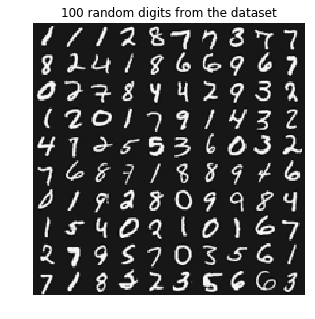

In [7]:
# Display data

sample = np.random.choice(x.shape[0], 100)

display_data(x[sample, 1:])    
plt.title('100 random digits from the dataset')
plt.set_cmap('Greys_r')
plt.axis('off')

plt.savefig(figsdir / 'data.png', bbox_inches='tight')

In [8]:
# Load weights

weights = loadmat(datadir / 'ex4weights.mat')
weights.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Theta1', 'Theta2'])

In [9]:
theta1 = weights['Theta1']
theta2 = weights['Theta2']

print('Theta1: {}\nTheta2: {}'.format(theta1.shape, theta2.shape))

Theta1: (25, 401)
Theta2: (10, 26)


In [10]:
def rand_initialize_weights(l_in, l_out):
    epsilon = 0.12
    
    return np.random.random((l_out, l_in + 1)) * 2 * epsilon - epsilon

In [11]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [12]:
def sigmoid_gradient(z):
    return sigmoid(z) * (1 - sigmoid(z))

In [13]:
def cost_function(nn_params, input_layer_size, hidden_layer_size, num_labels, x, y, reg=0):
    theta1 = nn_params[:(input_layer_size + 1) * hidden_layer_size].reshape((hidden_layer_size, input_layer_size + 1), order='F')
    theta2 = nn_params[(input_layer_size + 1) * hidden_layer_size:].reshape((num_labels, hidden_layer_size + 1), order='F')
    
    a2 = np.c_[np.ones(x.shape[0]), sigmoid(x.dot(theta1.T))]
    a3 = sigmoid(a2.dot(theta2.T))
    
    Y = pd.get_dummies(y.ravel()).values
    
    reg_term = np.sum(np.square(theta1[:, 1:])) + np.sum(np.square(theta2[:, 1:]))
    
    d3 = a3 - Y
    d2 = d3.dot(theta2) * np.c_[np.ones(x.shape[0]), sigmoid_gradient(x.dot(theta1.T))]
    
    del1 = d2[:, 1:].T.dot(x)
    del2 = d3.T.dot(a2)
    
    m = len(x)
    theta1_grad = del1 / m + (reg / m) * np.c_[np.zeros(theta1.shape[0]), theta1[:, 1:]]
    theta2_grad = del2 / m + (reg / m) * np.c_[np.zeros(theta2.shape[0]), theta2[:, 1:]]
    grad = np.r_[theta1_grad.ravel(order='F'), theta2_grad.ravel(order='F')]
    
    return -(np.sum(Y * (np.log(a3)) + (1 - Y) * (np.log(1 - a3))) - (reg/2) * (reg_term)) / m, grad

In [14]:
# Parameters

nn_params = np.r_[theta1.ravel(order='F'), theta2.ravel(order='F')]
input_layer_size = 400
hidden_layer_size = 25
num_labels = 10

In [15]:
J, _ = cost_function(nn_params, input_layer_size, hidden_layer_size, num_labels, x, y, reg=1)
print('Cost at parameters loaded from ex4weights (w/ lambda = 1): {}\n(this value should be about 0.383770)'.format(J))

Cost at parameters loaded from ex4weights (w/ lambda = 1): 0.38376985909092365
(this value should be about 0.383770)


In [16]:
g = sigmoid_gradient(np.array([-1, -0.5, 0, 0.5, 1]))
print('Sigmoid gradient evaluated at [-1 -0.5 0 0.5 1]: {}'.format(g))

Sigmoid gradient evaluated at [-1 -0.5 0 0.5 1]: [0.19661193 0.23500371 0.25       0.23500371 0.19661193]


In [17]:
J, _ = cost_function(nn_params, input_layer_size, hidden_layer_size, num_labels, x, y, reg=3)
print('Cost at (fixed) debugging parameters (w/ lambda = 3): {}\n(this value should be about 0.576051)'.format(J))

Cost at (fixed) debugging parameters (w/ lambda = 3): 0.5760512469501331
(this value should be about 0.576051)


In [18]:
# Parameter initialization

theta1 = rand_initialize_weights(400, 25)
theta2 = rand_initialize_weights(25, 10)

nn_params = np.r_[theta1.ravel(order='F'), theta2.ravel(order='F')]

res = minimize(cost_function, nn_params, args=(input_layer_size, hidden_layer_size, num_labels, x, y, 0.1),\
               method='CG', jac=True, options={'maxiter': 50})
print('Cost at random parameters (w/ lambda = 0.1): {}'.format(res.fun))

Cost at random parameters (w/ lambda = 0.1): 0.3153035825178696


In [19]:
# Unroll parameters

theta1 = res.x[:(input_layer_size + 1) * hidden_layer_size].reshape((hidden_layer_size, input_layer_size + 1), order='F')
theta2 = res.x[(input_layer_size + 1) * hidden_layer_size:].reshape((num_labels, hidden_layer_size + 1), order='F')

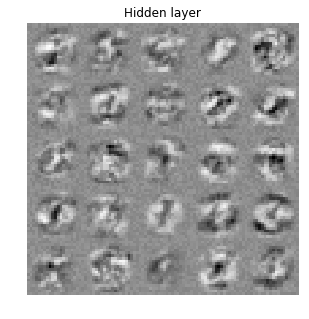

In [20]:
# Visualize the hidden layer

display_data(theta1[:, 1:])
plt.title('Hidden layer')
plt.set_cmap('Greys')
plt.axis('off')

plt.savefig(figsdir / 'hidden_layer.png', bbox_inches='tight')

In [21]:
def predict(theta1, theta2, x):
    h1 = np.c_[np.ones(x.shape[0]), sigmoid(x.dot(theta1.T))]
    h2 = sigmoid(h1.dot(theta2.T))
    
    return np.argmax(h2, axis=1) + 1

In [22]:
pred = predict(theta1, theta2, x)
print('Training set accuracy (neural network): {:.02f}%'.format(np.mean(pred == y.ravel()) * 100))

Training set accuracy (neural network): 96.50%
